In [51]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import gensim
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import numpy as np
import wordcloud

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud, STOPWORDS

print('Python Version: %s' % (sys.version))
%matplotlib inline

Python Version: 3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) 
[GCC 7.3.0]


## Load Everything
If you ever need to load dictionary, corpus and documents

In [3]:
os.chdir('/home/storopoli/Documents/jupyter_notebooks/textract/riae/')

In [3]:
import pickle
with open('documents', 'rb') as f: #load
    documents = pickle.load(f)
with open('texts', 'rb') as f: #load
    texts = pickle.load(f)
with open('lemmatized_output', 'rb') as f: #load
    lemmatized_output = pickle.load(f)

dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus = gensim.corpora.MmCorpus('corpus.mm')
lda_model = models.LdaModel.load('optimal_model_Gensim')
lda_model_mallet = models.wrappers.LdaMallet.load('optimal_model_Mallet')

print(dictionary)
print(corpus)
print(len(documents))
print(len(lemmatized_output))
print(lda_model)
print(lda_model_mallet)

/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


Dictionary(1025 unique tokens: ['compet', 'context', 'didá', 'empreg', 'estratég']...)
MmCorpus(164 documents, 1025 features, 5521 non-zero entries)
164
164
LdaModel(num_terms=1025, num_topics=14, decay=0.5, chunksize=100)


/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


To find that, we find the topic number that has the highest percentage contribution in that document.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [4]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [5]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_mallet, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic = df_dominant_topic.set_index('Document_No')
df_dominant_topic.head()

/home/storopoli/anaconda3/envs/topic-modeling/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,
159,5.0,0.1336,"fat, sustent, institu, question, adot, lideran...","(O, estudo, analisou, a, relação, do, poder, d..."
160,0.0,0.2242,"capac, organiz, competi, ambi, dinâm, vantag, ...","(Este, artigo, tem, como, objetivo, analisar, ..."
161,1.0,0.2192,"estratég, prát, form, ges, comport, explor, al...","(O, objetivo, do, presente, trabalho, consisti..."
162,2.0,0.2311,"desenvolv, recurs, relacion, ativ, capit, cres...","(O, objetivo, n, este, artigo, foi, compreende..."
163,7.0,0.2256,"model, negóci, conhec, context, qualit, empree...","(Conhecimento, e, inovação, sempre, caminharam..."


In [7]:
df_geral = pd.read_excel('riae-bibs-164.xlsx')
df_geral = df_geral.join(df_dominant_topic)
df_geral.head()

,CATEGORY,TITLE,AUTHOR,JOURNAL,YEAR,VOLUME,NUMBER,PAGES,ABSTRACT,URL,ISSN,TYPE,DOI,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,ARTICLE,Observação Participante e Não Participante: Co...,"Marietto, M. L.",Revista Ibero-Americana de Estratégia,2018,17,4,5-18,OBJETIVO DO ESTUDO: Fornecer explicações sobre...,http://www.spell.org.br/documentos/ver/51414/o...,2176-0756,Journal Article,10.5585/ ijsm.v17i4.2717,9.0,0.1502,"process, gest, entrev, particip, gerenc, envol...","(Fornecer, explicações, sobre, os, métodos, su..."
1,ARTICLE,Capacidades Dinâmicas em um Ambiente de Crise:...,"Barcelos, R. and Lopes, D. P. T. and Gonçalv...",Revista Ibero-Americana de Estratégia,2018,17,4,19-37,OBJETIVO DO TRABALHO: explorar evidências sobr...,http://www.spell.org.br/documentos/ver/51415/c...,2176-0756,Journal Article,10.5585/ ijsm.v17i4.2615,0.0,0.3053,"capac, organiz, competi, ambi, dinâm, vantag, ...","(OBJETIVO, DO, TRABALHO, explorar, evidências,..."
2,ARTICLE,A Competitividade do Setor de Telecomunicações...,"Muylder, C. F. and Falce, J. L. and Rodrigue...",Revista Ibero-Americana de Estratégia,2018,17,4,38-54,OBJETIVO: O objetivo deste trabalho consiste e...,http://www.spell.org.br/documentos/ver/51416/a...,2176-0756,Journal Article,10.5585/ ijsm.v17i4.2619,7.0,0.1584,"model, negóci, conhec, context, qualit, empree...","(OBJETIVO, O, objetivo, d, este, trabalho, con..."
3,ARTICLE,Um Modelo Conceitual para a Caracterização da ...,"Carmona, V. C. and Martens, C. D. P. and Fre...",Revista Ibero-Americana de Estratégia,2018,17,4,55-70,OBJETIVO DO ESTUDO: O objetivo do presente art...,http://www.spell.org.br/documentos/ver/51417/u...,2176-0756,Journal Article,10.5585/ ijsm.v17i4.2627,7.0,0.2657,"model, negóci, conhec, context, qualit, empree...","(O, objetivo, do, presente, artigo, é, propor,..."
4,ARTICLE,O Efeito Moderador das Capabilidades da Manufa...,"Vitorino Filho, V. A. and Moori, R. G.",Revista Ibero-Americana de Estratégia,2018,17,4,71-89,OBJETIVO DO ESTUDO: o objetivo deste artigo é ...,http://www.spell.org.br/documentos/ver/51418/o...,2176-0756,Journal Article,10.5585/ ijsm.v17i4.2634,5.0,0.3216,"fat, sustent, institu, question, adot, lideran...","(o, objetivo, d, este, artigo, é, investigar, ..."


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Apend Document Data by index
sent_topics_sorteddf_mallet = pd.merge(sent_topics_sorteddf_mallet, df_geral, left_index=True, right_index=True)

#save
sent_topics_sorteddf_mallet.to_excel('most-representative-document-for-topic.xlsx')

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib_x,Keywords_x,Text_x,CATEGORY,TITLE,AUTHOR,JOURNAL,YEAR,VOLUME,...,PAGES,ABSTRACT,URL,ISSN,TYPE,DOI,Dominant_Topic,Topic_Perc_Contrib_y,Keywords_y,Text_y
157,0.0,0.3501,"capac, organiz, competi, ambi, dinâm, vantag, ...","(Uma, consideração, expandida, é, necessária, ...",ARTICLE,An analytical framework for Miles and Snow typ...,"Martins, T. S. and Kato, H. T. and Martins, ...",Revista Ibero-Americana de Estratégia,2014,13,...,22-33,Uma consideração expandida é necessária para e...,http://www.spell.org.br/documentos/ver/31713/a...,2176-0756,Journal Article,10.5585 / riae.v13i1.1934,0.0,0.3501,"capac, organiz, competi, ambi, dinâm, vantag, ...","(Uma, consideração, expandida, é, necessária, ..."
61,1.0,0.4331,"estratég, prát, form, ges, comport, explor, al...","(Este, ensaio, teórico, objetivou, analisar, a...",ARTICLE,Da Estratégia Clássica à Estratégia como Práti...,"Villar, E. G. and Walter, S. A. and Braum, L...",Revista Ibero-Americana de Estratégia,2017,16,...,8-21,Este ensaio teórico objetivou analisar as conc...,http://www.spell.org.br/documentos/ver/45007/d...,2176-0756,Journal Article,10.5585/riae.v16i1.2409,1.0,0.4331,"estratég, prát, form, ges, comport, explor, al...","(Este, ensaio, teórico, objetivou, analisar, a..."
35,2.0,0.4828,"desenvolv, recurs, relacion, ativ, capit, cres...","(O, presente, estudo, investiga, os, determina...",ARTICLE,Determinantes da Estrutura de Capital de Empre...,"Henrique, M. R. and Silva, S. B. and Soares,...",Revista Ibero-Americana de Estratégia,2018,17,...,130-144,O presente estudo investiga os determinantes d...,http://www.spell.org.br/documentos/ver/49231/d...,2176-0756,Journal Article,10.5585/riae.v17i1.2542,2.0,0.4828,"desenvolv, recurs, relacion, ativ, capit, cres...","(O, presente, estudo, investiga, os, determina..."
101,3.0,0.5467,"empr, inform, estrut, corpor, financ, efici, g...","(Este, estudo, objetiva, verificar, a, influên...",ARTICLE,Influência da Estrutura de Governança Corporat...,"Bach, T. M. and Kudlawicz, C. and Silva, E. D.",Revista Ibero-Americana de Estratégia,2015,14,...,41-62,Este estudo objetiva verificar a influência da...,http://www.spell.org.br/documentos/ver/39124/i...,2176-0756,Journal Article,10.5585/ijsm.v14i4.2212,3.0,0.5467,"empr, inform, estrut, corpor, financ, efici, g...","(Este, estudo, objetiva, verificar, a, influên..."
78,4.0,0.3990,"teor, conceit, internac, futur, teór, caracter...","(A, presente, pesquisa, teve, como, objetivo, ...",ARTICLE,Avaliação de Desempenho na Contabilidade Geren...,"Souza, F. F. and Ensslin, S. R. and Gasparet...",Revista Ibero-Americana de Estratégia,2016,15,...,20-38,A presente pesquisa teve como objetivo analisa...,http://www.spell.org.br/documentos/ver/42892/a...,2176-0756,Journal Article,10.5585/riae.v15i3.2308,4.0,0.3990,"teor, conceit, internac, futur, teór, caracter...","(A, presente, pesquisa, teve, como, objetivo, ..."


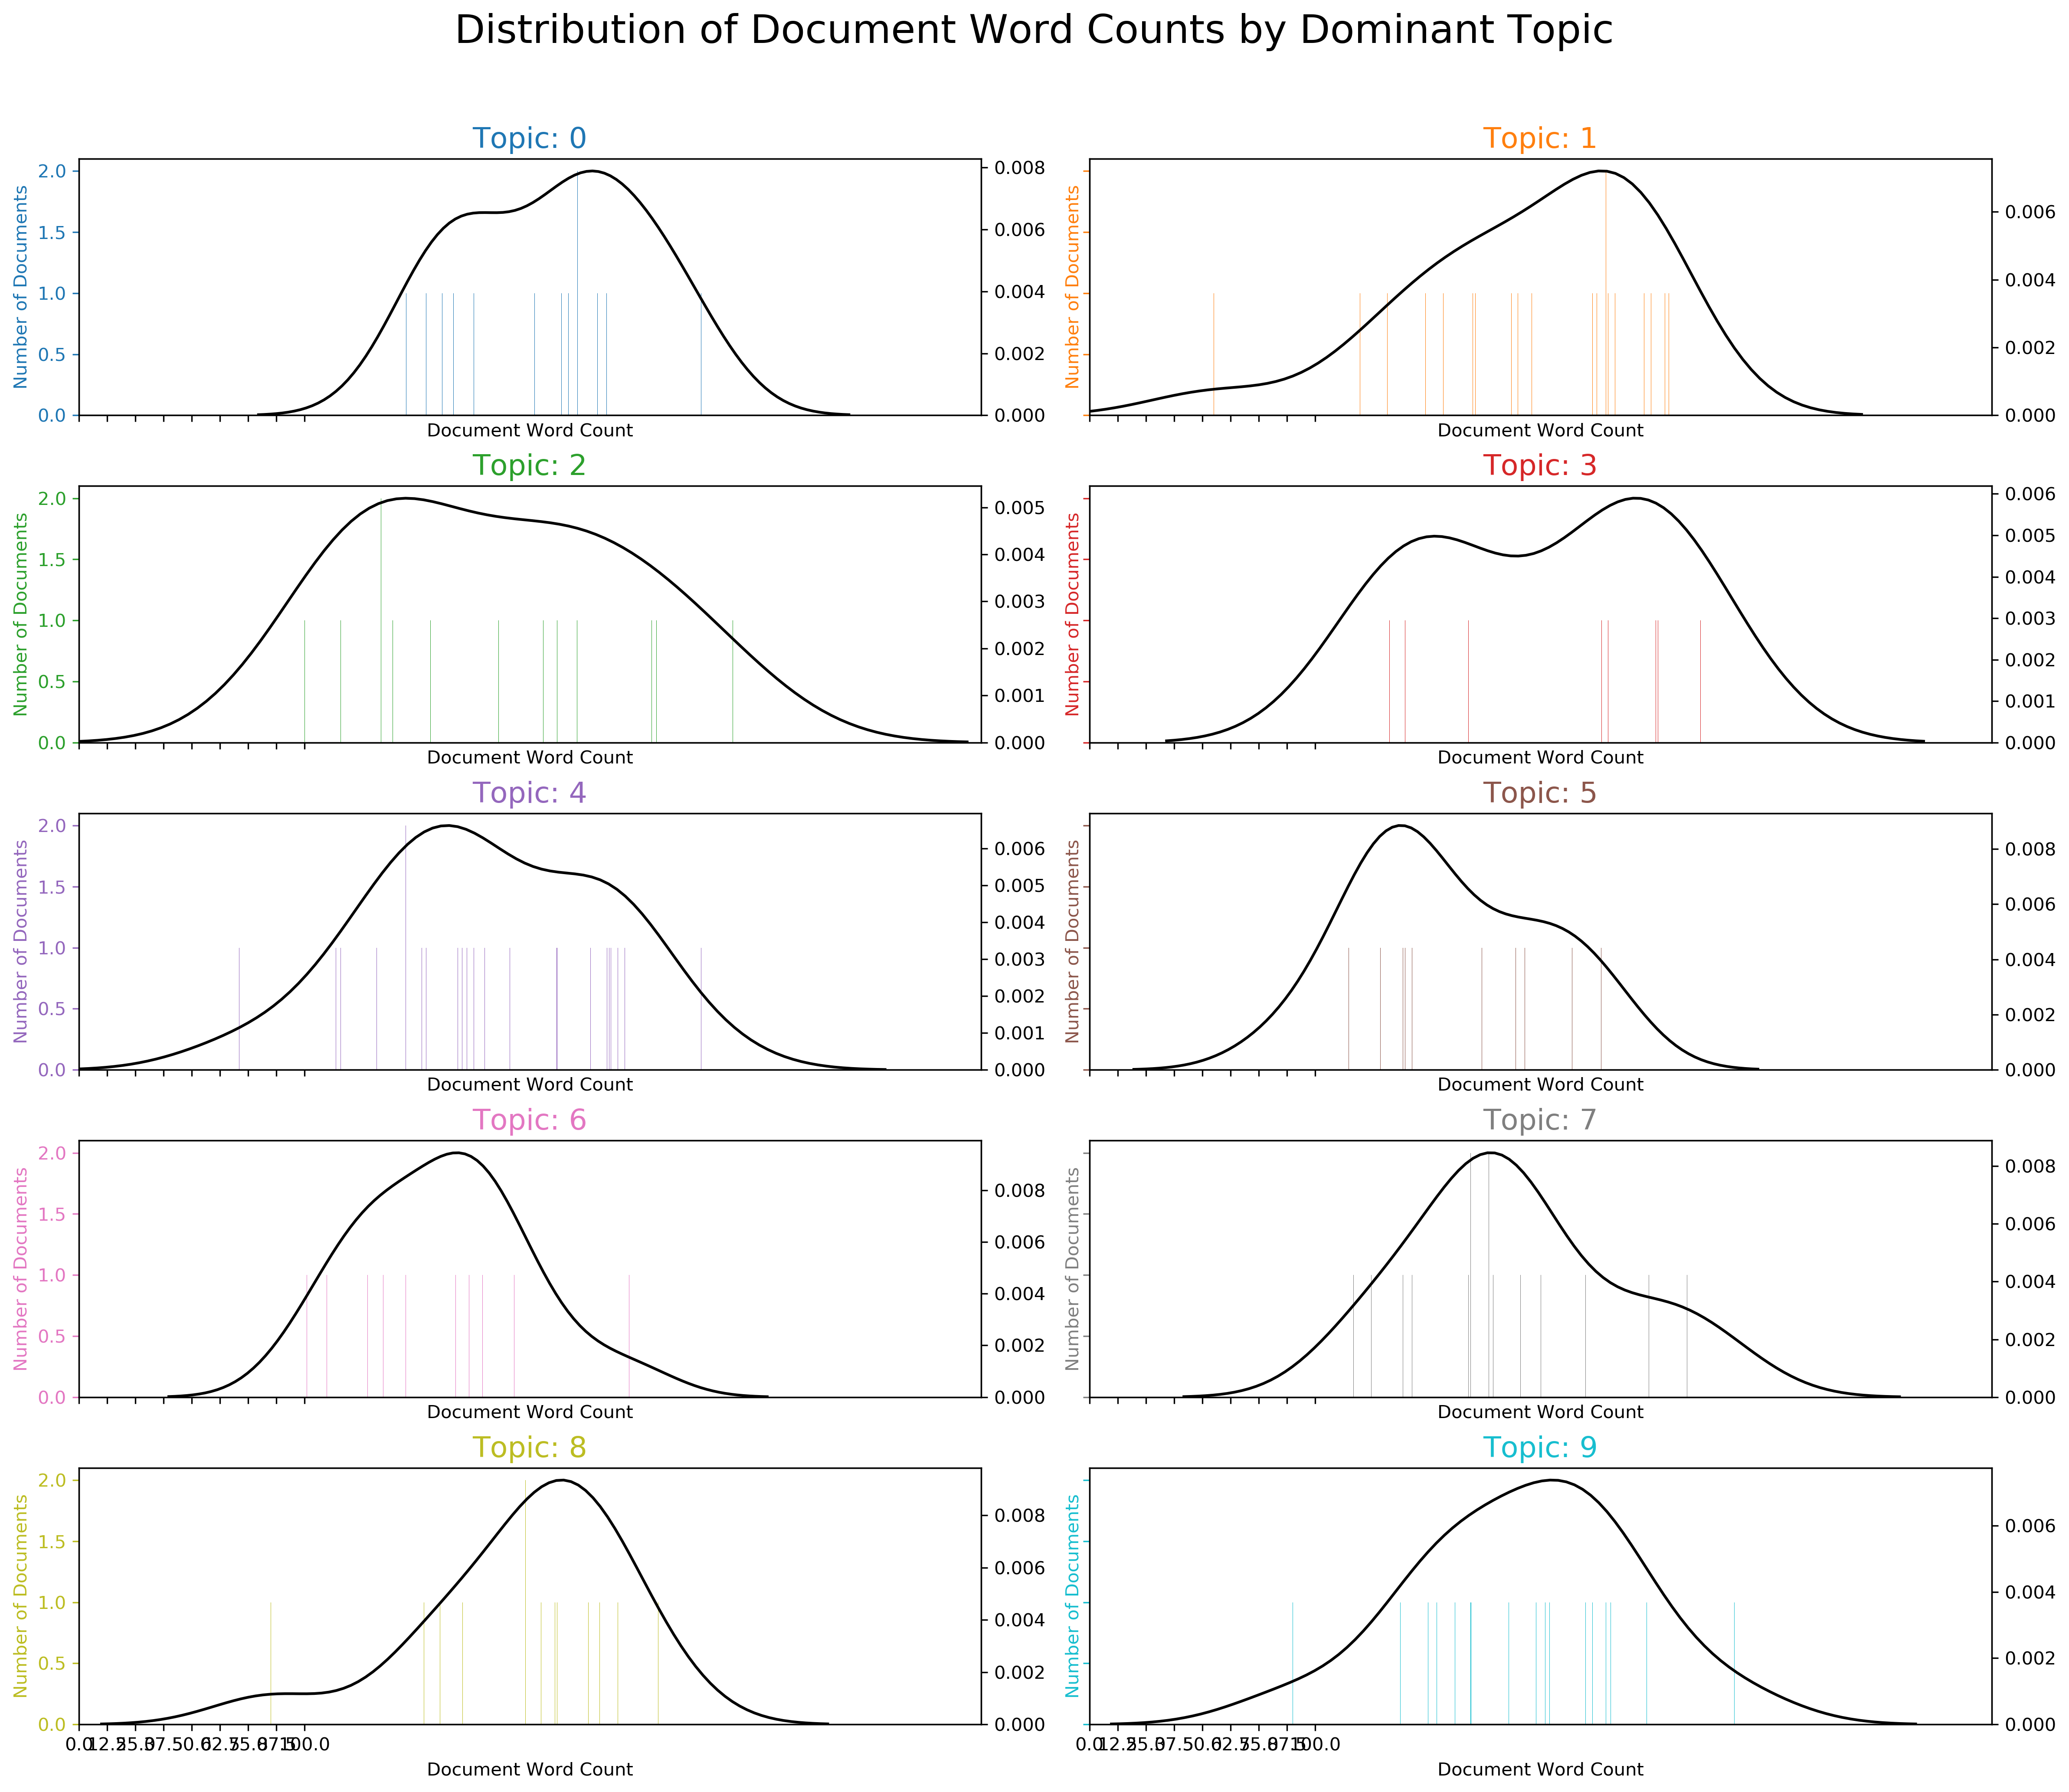

In [133]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=300, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig('document-word-count-by-dominant-topic.jpg')
plt.show()

## Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

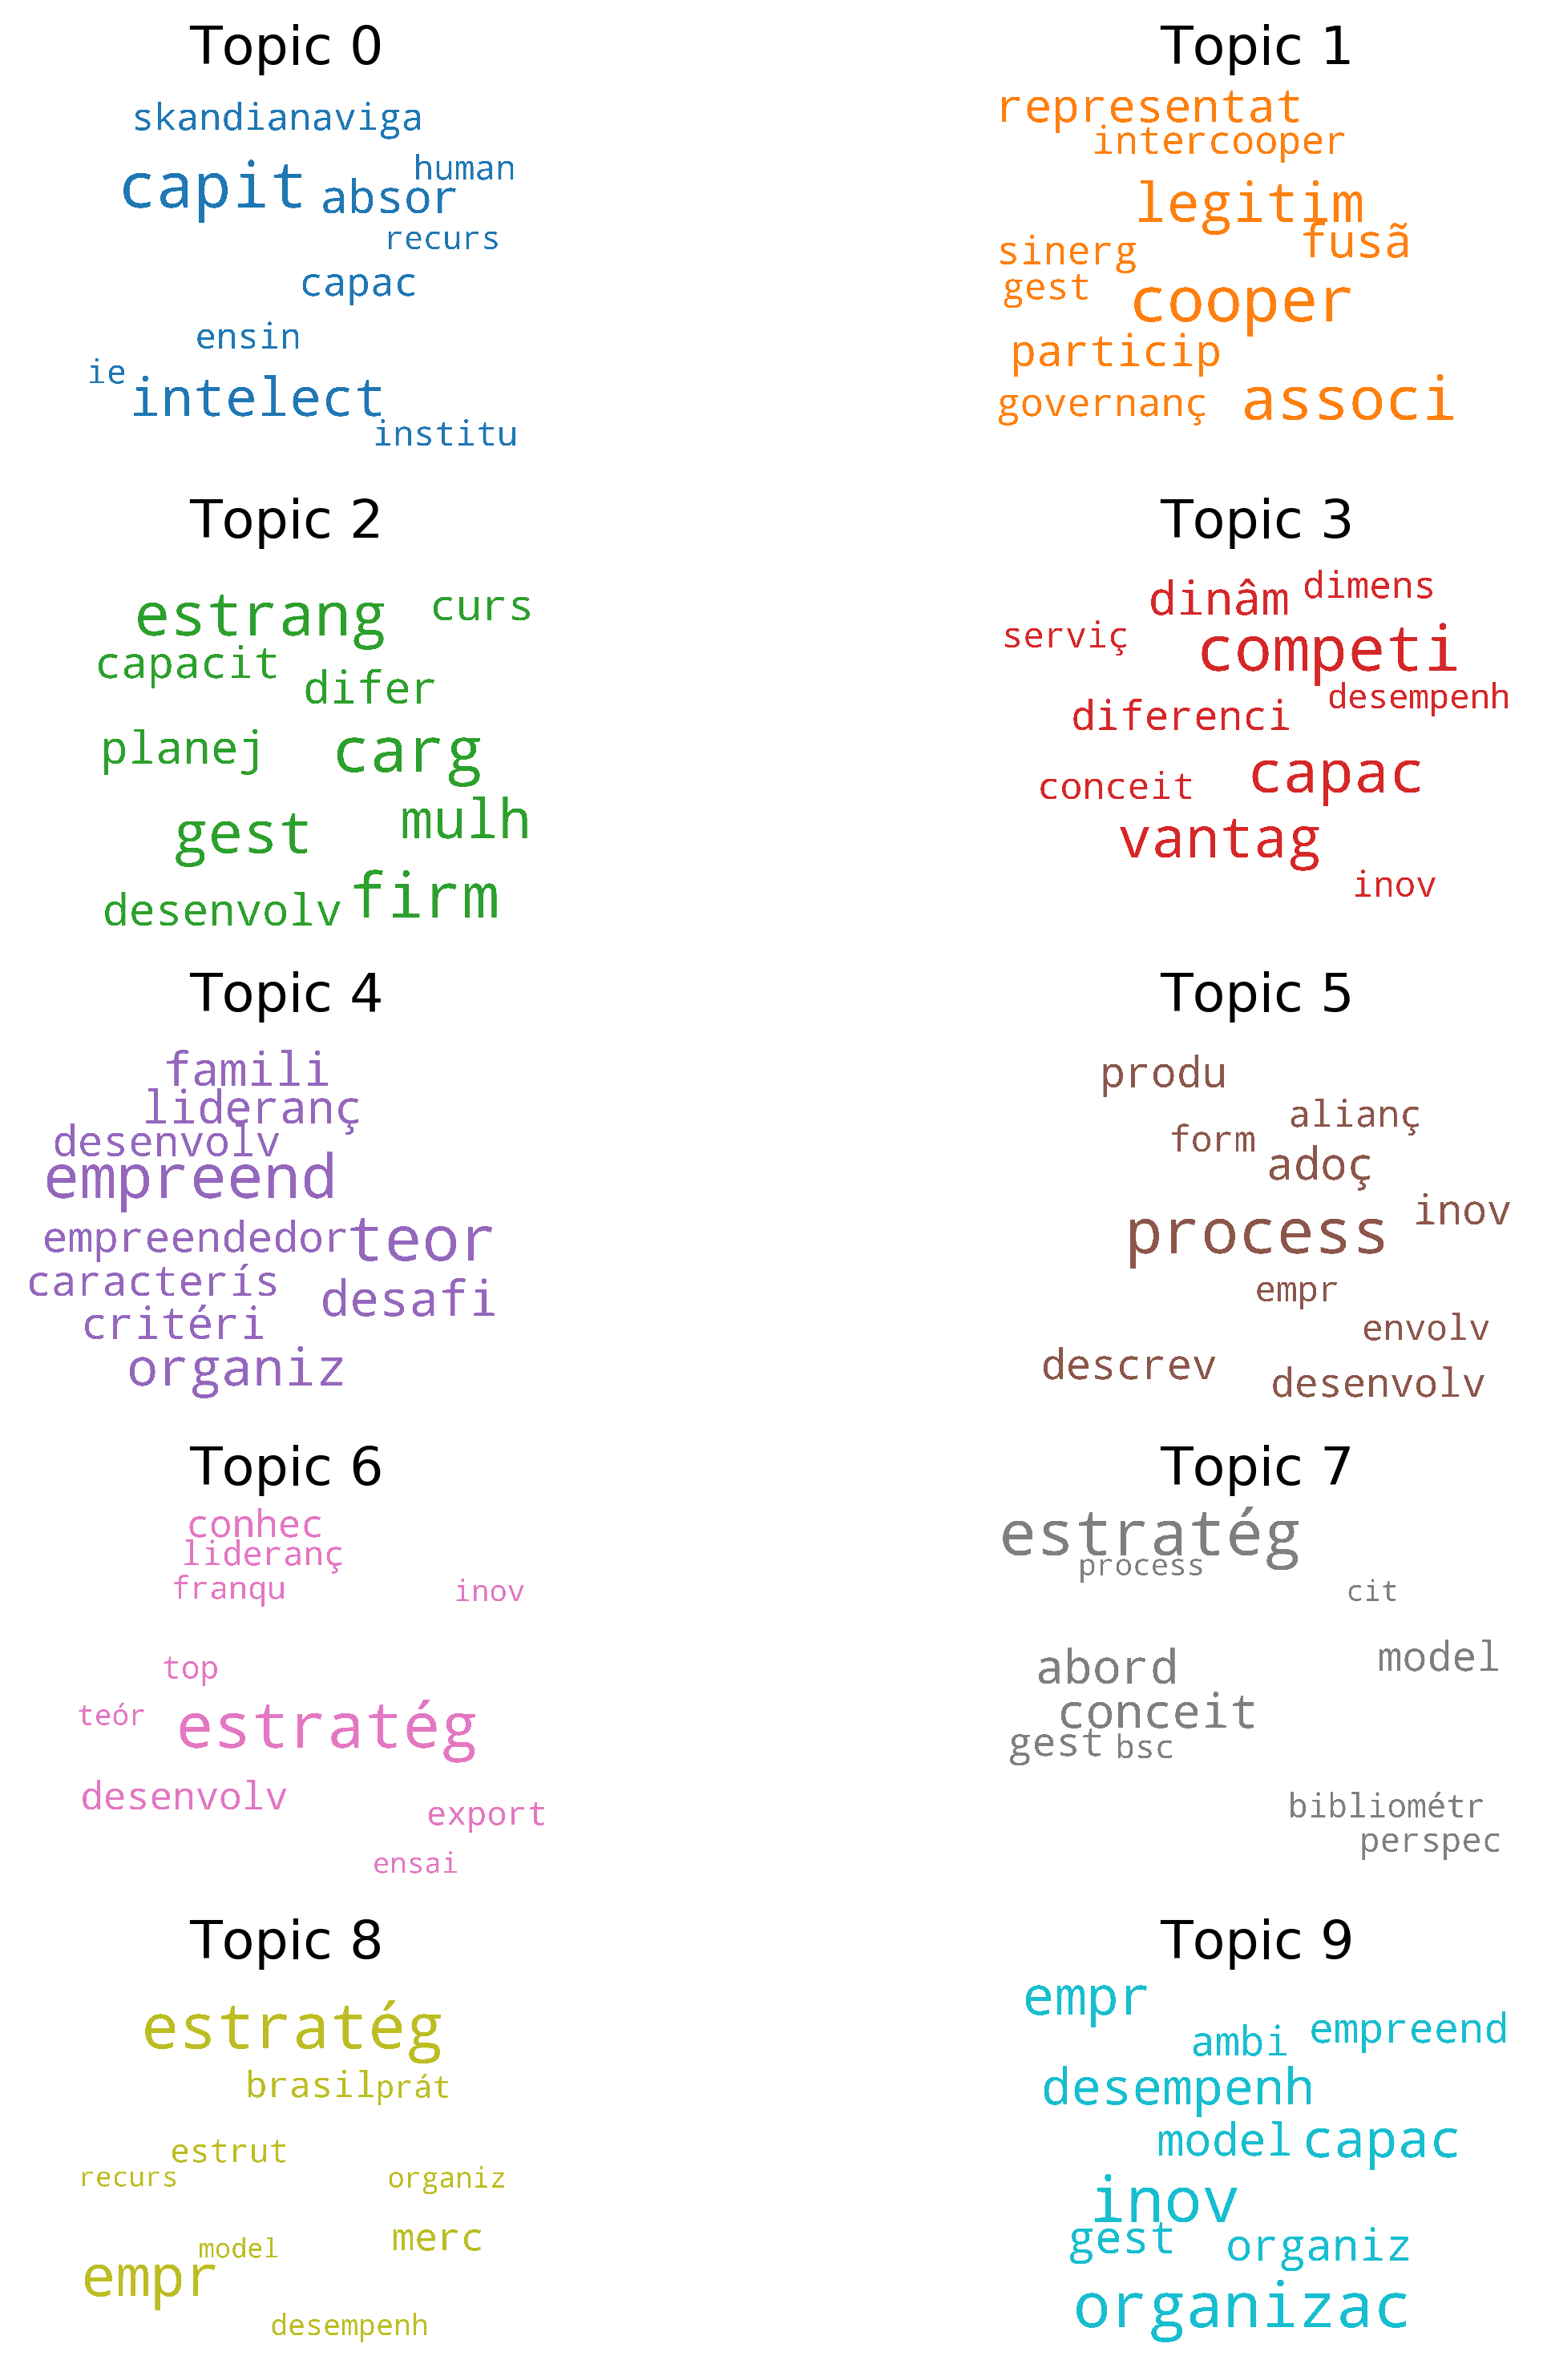

In [134]:
# 1. Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True, dpi=300)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Wordcloud-top10-for-each-topic.jpg')
plt.show()

## Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

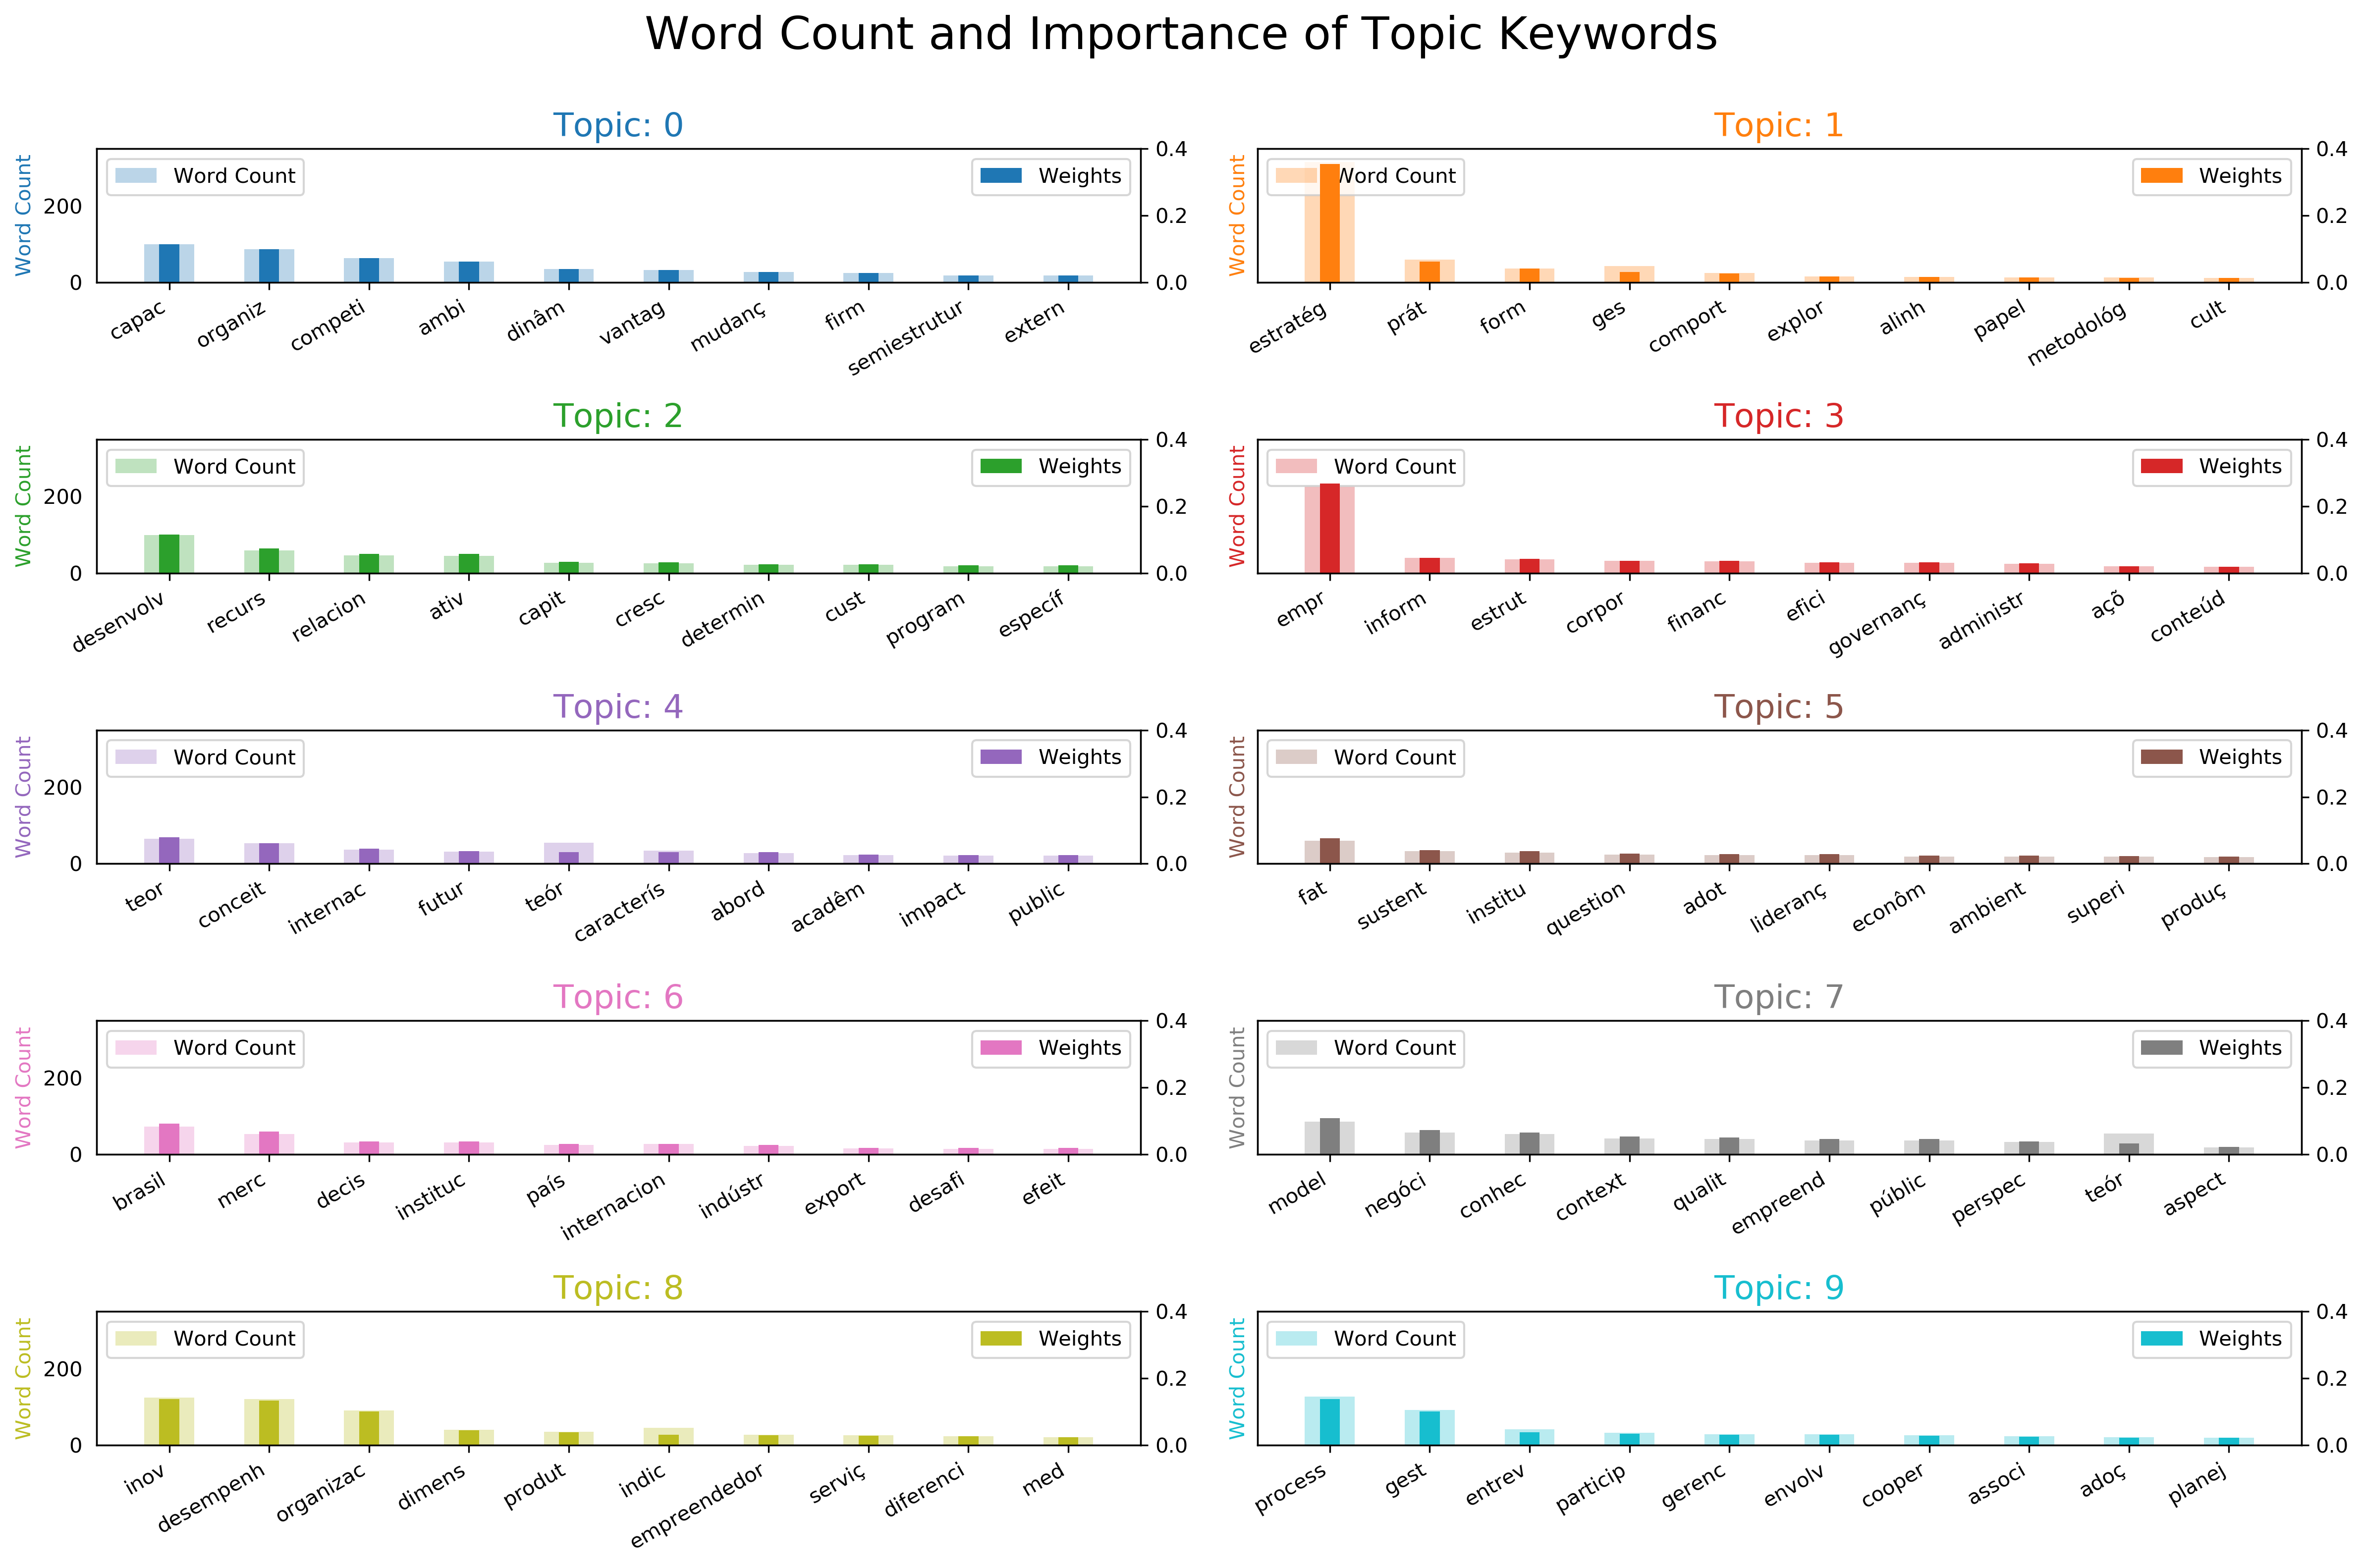

In [135]:
from collections import Counter


topics = lda_model_mallet.show_topics(formatted=False)
data_flat = [w for w_list in lemmatized_output for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=300)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.40); ax.set_ylim(0, 350)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.savefig('Word-count-importance-of-topic-kw.jpg')
plt.show()

## Topic Prevalence over the years

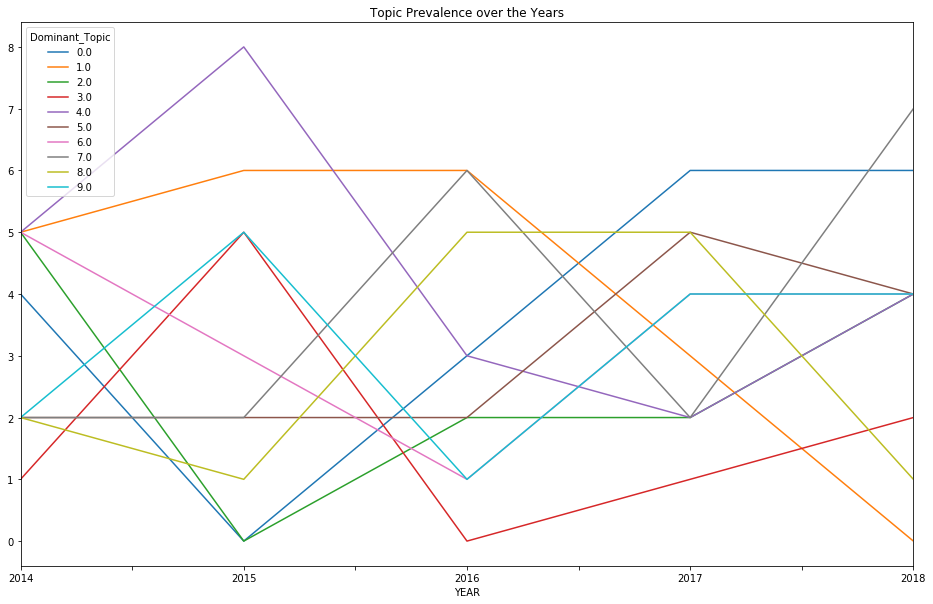

In [132]:
df_geral.groupby(['YEAR','Dominant_Topic'])['Dominant_Topic'].size().unstack(fill_value=0).plot(
figsize=(16,10),
title = 'Topic Prevalence over the Years')
plt.savefig('topic-predominance-per-year.jpg',dpi=300)